In [1]:
import pandas as pd
import zstandard as zstd
import json

In [2]:
paths = 'data/UCSD_submissions.zst'

In [3]:
data = []
with open("data/UCSD_submissions.zst", 'rb') as fh:
    dctx = zstd.ZstdDecompressor(max_window_size=2147483648)
    with dctx.stream_reader(fh) as reader:
        previous_line = ""
        while True:
            chunk = reader.read(2**24)  # 16mb chunks
            if not chunk:
                break

            string_data = chunk.decode('utf-8')
            lines = string_data.split("\n")
            for i, line in enumerate(lines[:-1]):
                if i == 0:
                    line = previous_line + line
                object = json.loads(line)
                data.append(object)
                # do something with the object here
            previous_line = lines[-1]
with open("data/UCSD_comments.zst", 'rb') as fh:
    dctx = zstd.ZstdDecompressor(max_window_size=2147483648)
    with dctx.stream_reader(fh) as reader:
        previous_line = ""
        while True:
            chunk = reader.read(2**24)  # 16mb chunks
            if not chunk:
                break

            string_data = chunk.decode('utf-8')
            lines = string_data.split("\n")
            for i, line in enumerate(lines[:-1]):
                if i == 0:
                    line = previous_line + line
                object = json.loads(line)
                data.append(object)
                # do something with the object here
            previous_line = lines[-1]
df = pd.DataFrame(data)

In [4]:
df.head()

,archived,author,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_text_color,author_flair_type,brand_safe,can_gild,...,is_submitter,quarantined,steward_reports,associated_award,collapsed_because_crowd_control,comment_type,collapsed_reason_code,author_is_blocked,unrepliable_reason,editable
0,True,spleeyah,None,,"[{'e': 'text', 't': 'Class of '12 | Q29tcHV0ZX...",Class of '12 | Q29tcHV0ZXIgU2NpZW5jZQo= (B.S.),None,richtext,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,True,spleeyah,None,,"[{'e': 'text', 't': 'Class of '12 | Q29tcHV0ZX...",Class of '12 | Q29tcHV0ZXIgU2NpZW5jZQo= (B.S.),None,richtext,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,True,[deleted],,None,NaN,None,dark,NaN,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,True,xxbondsxx,None,None,[],None,None,text,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,True,SnowdensOfYesteryear,None,None,[],None,None,text,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# see all the columns
for i in range(0, len(df.columns), 10):
    print(df.columns[i:i+10])

Index(['archived', 'author', 'author_flair_background_color',
       'author_flair_css_class', 'author_flair_richtext', 'author_flair_text',
       'author_flair_text_color', 'author_flair_type', 'brand_safe',
       'can_gild'],
      dtype='object')
Index(['contest_mode', 'created_utc', 'distinguished', 'domain', 'edited',
       'gilded', 'hidden', 'hide_score', 'id', 'is_crosspostable'],
      dtype='object')
Index(['is_reddit_media_domain', 'is_self', 'is_video', 'link_flair_css_class',
       'link_flair_richtext', 'link_flair_text', 'link_flair_text_color',
       'link_flair_type', 'locked', 'media'],
      dtype='object')
Index(['media_embed', 'no_follow', 'num_comments', 'num_crossposts', 'over_18',
       'parent_whitelist_status', 'permalink', 'retrieved_on', 'rte_mode',
       'score'],
      dtype='object')
Index(['secure_media', 'secure_media_embed', 'selftext', 'send_replies',
       'spoiler', 'stickied', 'subreddit', 'subreddit_id',
       'subreddit_name_prefixed', '

In [6]:
df.shape

(814431, 146)

## Data Wrangling

To reduce the dataset and keep it relevant, I will only use the posts from beginning of 2017 to end of 2022.

In [7]:
dates = pd.to_datetime(df['created_utc'], unit = 's')

In [8]:
# to reduce the dataset, find entries that date from the beginning of 2017
df['created_date'] = dates
new_df = df[df['created_date'] >= '2017-1-01']

In [9]:
new_df.shape

(706829, 147)

In [10]:
# get necessary text from selftext (the content of the original submissions)
# and the bodies of comments of the submissions
new_df = new_df[['selftext','body']]

In [11]:
# we can see that one of the two, selftext and body columns, are nan as they only can have one or the other.
new_df.head()

,selftext,body
12183,Happy New Year UCSD! Hope everyone reflected o...,NaN
12184,Friday so you can have the weekend to chill? T...,NaN
12185,Since the S. Quarterly parking permit isn't av...,NaN
12186,I'm at a loss nowadays. I'm a third year NanoE...,NaN
12187,"Hey guys, \n\nI'm wondering what the best way ...",NaN


In [12]:
# set dataframe to contain both selftext and body columns into a combined column called text
text = new_df['selftext'].fillna(new_df['body'])
combined = pd.DataFrame(text)
combined.columns = ['text']
combined.head()

,text
12183,Happy New Year UCSD! Hope everyone reflected o...
12184,Friday so you can have the weekend to chill? T...
12185,Since the S. Quarterly parking permit isn't av...
12186,I'm at a loss nowadays. I'm a third year NanoE...
12187,"Hey guys, \n\nI'm wondering what the best way ..."


In [13]:
# remove all the '[removed]', '[deleted]', and empty entries for text
cond1 = ~(combined['text'] == '')
cond2 = ~(combined['text'] == '[removed]')
cond3 = ~(combined['text'] == '[deleted]')
combined = combined[cond1 & cond2 & cond3]
combined.shape

(624471, 1)

In [14]:
# save combined
combined.head()

,text
12183,Happy New Year UCSD! Hope everyone reflected o...
12184,Friday so you can have the weekend to chill? T...
12185,Since the S. Quarterly parking permit isn't av...
12186,I'm at a loss nowadays. I'm a third year NanoE...
12187,"Hey guys, \n\nI'm wondering what the best way ..."


### Cleaning

In [27]:
import re
import string
import random
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk

In [18]:
# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nick\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nick\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [278]:
def clean_text(text):
    # Lowercasing
#     text = text.lower()
    
    # Removing URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Removing special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    
    # Tokenization
    words = word_tokenize(text)
    
    # Removing stopwords
    stopwords_set = set(stopwords.words('english'))
    words = [word for word in words if word not in stopwords_set]

    return ' '.join(words)

In [279]:
text = ' '.join(combined['text'].values)

In [280]:
cleaned_text = clean_text(text)

In [281]:
cleaned_text[:500]

'Happy New Year UCSD Hope everyone reflected worked didnt Lets start year strong Friday weekend chill Tomorrow hate life home Sunday night time rushing monday Since S Quarterly parking permit isnt available online I drive Gilman parking structure pay permit Would office open Sunday Im loss nowadays Im third year NanoEngineering major Im starting realize major black hole employers dont know opportunities seem scarce undergrad degree On bright side getting ABET accreditation soon I dont even know I'

In [282]:
text_len = len(cleaned_text)

In [283]:
chunk_len = 150

def random_chunk():
    start_index = random.randint(0, len(cleaned_text) - chunk_len-1)
    end_index = start_index + chunk_len + 1
    return cleaned_text[start_index:end_index]

print(random_chunk())

hone interview mainly behavior screening test really sees good fit add team technical interview I really recommend also go interviews write interview q


### Modeling

In [284]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [285]:
import string
import random
import re

In [286]:
all_characters = sorted(set(cleaned_text))
n_characters = len(all_characters)

In [288]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, text_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return cleaned_text[start_index:end_index]

print(random_chunk())

 living situation campus worsen homesickness Pure Math Math A nothing laugh Thats sad even worse definitely werent one Why scared Just go ask front desk good bro theyre real friendly understand probs h


In [289]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abc'))

tensor([27, 28, 29])


In [290]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1]).to(device)  # Move to device
    target = char_tensor(chunk[1:]).to(device)  # Move to device
    return inp, target

In [291]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    # Ensure the decoder is in eval mode
    decoder.eval()

    # Move the decoder's initial hidden state to the correct device
    hidden = decoder.init_hidden().to(device)

    # Convert the prime string to a tensor and move it to the correct device
    prime_input = char_tensor(prime_str).to(device)

    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p].unsqueeze(0), hidden)
    inp = prime_input[-1]

    for p in range(predict_len):
        # Make sure to add an extra dimension for batch size = 1
        output, hidden = decoder(inp.unsqueeze(0), hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Move the predicted index back to CPU for processing
        predicted_char = all_characters[top_i.item()]
        predicted += predicted_char

        # Convert the predicted character to a tensor for the next input
        inp = char_tensor(predicted_char).to(device)

    # Switch back to training mode
    decoder.train()
    
    return predicted


In [292]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [293]:
def train(inp, target):
    hidden = decoder.init_hidden().to(device)  # Initialize hidden state and move to device
    inp, target = inp.to(device), target.to(device)  # Move input and target tensors to device
    
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c].unsqueeze(0), hidden)
        loss += criterion(output, target[c].unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()

    return loss.item() / chunk_len


In [296]:
n_epochs = 5000
print_every = 250
plot_every = 100
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder = decoder.to(device)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Ge', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 17s (250 5%) 2.4922]
Gent Ceat Sept food neresty Iver pisting CeHHHHHHYUque cants nand compur eamn injorlison indenteras I  

 34s (500 10%) 1.8605]
Gem hrad class adurescessate one sam I opleatitioule fance see You I stronymenth dorym anywow anyhould 

 51s (750 15%) 1.8974]
Ger actad It foullan farting sumpers dont Bair Thanks Its Tuity take sone finance fund raus Tins compl 

 9s (1000 20%) 1.6403]
Gesson us Moy got bion live Maybely quarter Deavil look around t invants I thou Chorm This majore ligh 

 26s (1250 25%) 1.6041]
Gets think tooks tolle under seconsuble make treality So gan worrily prign stuad UCSD lot got wnouble  

 44s (1500 30%) 1.6187]
Gerce probates CSE mobled Sing ecess perfapastlers happose oking rang changle event genering though I  

 1s (1750 35%) 1.6453]
Geg reaso Yus Right proces Nectually year tower canting time us Not see wainter college If bits class  

 18s (2000 40%) 1.9496]
Ger start anothunilaon Masises cirding housing tryphs contill School event back

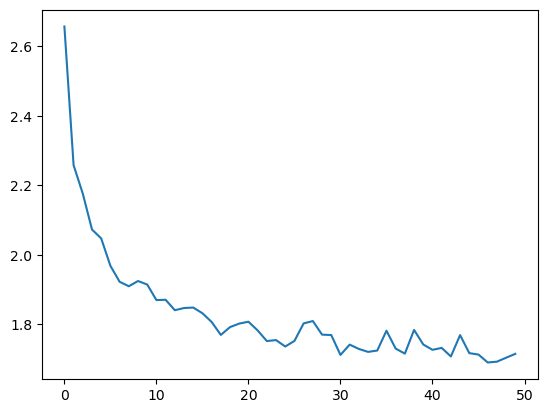

In [298]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [395]:
evaluate('reve', 100, temperature = 0.2)

'reven students everyone students content check course check check everyone make students also completely'